In [1]:
"""
A Keras model for sem seg on Christine's drone footage
"""
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from keras import layers, Sequential
from keras.layers import Input, Dense, Activation, Cropping2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Concatenate, Reshape
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model, to_categorical
from keras.optimizers import Adam, RMSprop
from keras import backend as K
#from FCN_utils import *
from keras.metrics import categorical_accuracy
import glob

#from sklearn.metrics import confusion_matrix

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt

#https://stats.stackexchange.com/questions/285255/nns-multiple-sigmoid-binary-cross-entropy-giving-better-results-than-softmax
#Try with binary crossentropy, cateogrical_accuracy

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
INPUT_SHAPE = (372,372,14) 
BATCH_SIZE = 12
#N_CLASSES = 7
MAX_ITERATIONS = 100
LEARNING_RATE=5e-7


In [3]:
all_files = glob.glob('./trn_data_372/*')
print (all_files)

m = len(all_files)

a = np.load(all_files[0])
print (a.files)
print (a['data'].shape)

all_data = np.zeros((m,*a['data'].shape))
all_annotations = np.zeros((m,*a['annotation'].shape))

print (all_data.shape)

ii=0
for f in all_files:
    inp = np.load(f)
    all_data[ii,:,:,:] = inp['data']
    all_annotations[ii,:,:] = inp['annotation']
    ii+=1



print (np.unique(a['annotation']))
print (np.unique(all_annotations))
all_annotations[all_annotations==64.]=0
all_annotations[all_annotations==96.]=0
all_annotations[all_annotations==255]=1

print (np.unique(all_annotations))
print ((a['data']/10000.).clip(0.0,1.0))

['./trn_data_372/77.npz', './trn_data_372/2.npz', './trn_data_372/67.npz', './trn_data_372/74.npz', './trn_data_372/52.npz', './trn_data_372/0.npz', './trn_data_372/36.npz', './trn_data_372/40.npz', './trn_data_372/11.npz', './trn_data_372/60.npz', './trn_data_372/20.npz', './trn_data_372/44.npz', './trn_data_372/45.npz', './trn_data_372/39.npz', './trn_data_372/62.npz', './trn_data_372/32.npz', './trn_data_372/59.npz', './trn_data_372/33.npz', './trn_data_372/53.npz', './trn_data_372/8.npz', './trn_data_372/30.npz', './trn_data_372/68.npz', './trn_data_372/50.npz', './trn_data_372/47.npz', './trn_data_372/25.npz', './trn_data_372/55.npz', './trn_data_372/64.npz', './trn_data_372/18.npz', './trn_data_372/84.npz', './trn_data_372/6.npz', './trn_data_372/41.npz', './trn_data_372/13.npz', './trn_data_372/76.npz', './trn_data_372/24.npz', './trn_data_372/46.npz', './trn_data_372/43.npz', './trn_data_372/65.npz', './trn_data_372/38.npz', './trn_data_372/54.npz', './trn_data_372/66.npz', './

In [4]:
train_images = (all_data/10000.).clip(0.0,1.0)

#train_annotations = np.reshape(all_annotations, (-1,372*372))#to_categorical(all_annotations)
train_annotations = np.reshape(to_categorical(all_annotations), (-1,372*372,2))
N_CLASSES = 2#train_annotations.shape[-1]

print (N_CLASSES)
print (train_annotations.shape)

#train_annotations = to_categorical(train_annotations, num_classes=N_CLASSES)
#N_CLASSES=train_annotations.shape[-1]


2
(88, 138384, 2)


In [5]:
def UNET(input_shape):
    
    inputs = Input(input_shape)
    
    reshape_inp = Reshape((372,372,14))(inputs)


    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(reshape_inp)

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)


    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)


    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)


    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = Concatenate(axis=3)([drop4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = Concatenate(axis=3)([Cropping2D(((1,0),(1,0)))(conv3),up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = Concatenate(axis=3)([Cropping2D((1,1))(conv2),up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    
    inter9 = ZeroPadding2D(padding=(2,2))(UpSampling2D(size = (2,2))(conv8))

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inter9)
    merge9 = Concatenate(axis=3)([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(N_CLASSES, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(N_CLASSES, 3, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #sigmoid probably too strong an activation
    reshape10 = Reshape((372*372,N_CLASSES))(conv9)
                        
    #arg_out = Lambda(lambda x: K.argmax(x, axis=-1))(reshape10)
    #arg_out = Lambda(lambda x: K.cast(x, 'float'))(arg_out)
    #arg_out = Lambda(lambda x: K.squeeze(x, axis=-1))(arg_out)
    
    model = Model(input = inputs, output = reshape10)

    return model

In [6]:
semseg_model = UNET(INPUT_SHAPE)

opt = Adam(lr=1e-5)


semseg_model.compile(optimizer = opt, loss='binary_crossentropy', metrics=[categorical_accuracy], sample_weight_mode='temporal')
#This is the right kind of loss - but need to sort the nans out of the loss - maybe the traning data has all-zeros rows? and needs to be one-hot [0 1 0]

#semseg_model.fit(x = train_images, y = train_annotations, epochs = 1, batch_size = BATCH_SIZE)
print (semseg_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 372, 372, 14) 0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 372, 372, 14) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 372, 372, 64) 8128        reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 372, 372, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


In [17]:
print (train_annotations.shape)

weighting=np.zeros((train_annotations.shape[0], 372*372))
weighting[np.argmax(train_annotations, axis=-1)==1] = 0.9
weighting[np.argmax(train_annotations, axis=-1)==0] = 0.1

#weighting.shape= (m,h*w)
#annotations.shape = (m,h*w,c)



history = semseg_model.fit(x=train_images, y=train_annotations, validation_split=0.125, sample_weight=weighting, verbose=1, batch_size=11, epochs=15)
#semseg_model.fit_generator(train_dataset_reader, steps_per_epoch=4, epochs=5, verbose=1, use_multiprocessing=True, workers=4)

(88, 138384, 2)
Train on 77 samples, validate on 11 samples
Epoch 1/15
77/77 [==============================] - 27s 356ms/step - loss: 0.0470 - categorical_accuracy: 0.9609 - val_loss: 0.0670 - val_categorical_accuracy: 0.9834
Epoch 2/15
77/77 [==============================] - 28s 358ms/step - loss: 0.0469 - categorical_accuracy: 0.9593 - val_loss: 0.0657 - val_categorical_accuracy: 0.9812
Epoch 3/15
77/77 [==============================] - 28s 358ms/step - loss: 0.0464 - categorical_accuracy: 0.9575 - val_loss: 0.0577 - val_categorical_accuracy: 0.9842
Epoch 4/15
77/77 [==============================] - 28s 359ms/step - loss: 0.0487 - categorical_accuracy: 0.9689 - val_loss: 0.0682 - val_categorical_accuracy: 0.9775
Epoch 5/15
77/77 [==============================] - 28s 360ms/step - loss: 0.0470 - categorical_accuracy: 0.9633 - val_loss: 0.0650 - val_categorical_accuracy: 0.9717
Epoch 6/15
77/77 [==============================] - 28s 360ms/step - loss: 0.0456 - categorical_accuracy:

In [ ]:
print (history.history)
epochs = np.arange(len(history.history['val_loss']))
plt.plot(epochs, history.history['loss'], label='loss')
plt.plot(epochs, history.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [10]:
train_images_sample = train_images[20:40,:,:,:]
train_annotations_sample = np.reshape(train_annotations[20:40,:,:], (-1, 372,372,2))

In [13]:
prediction = np.reshape(semseg_model.predict(x=train_images_sample), (-1,372,372,2))

In [14]:
print(prediction.shape)
print (train_annotations_sample.shape)
print (train_annotations_sample[2,100,25,:])
print (prediction[2,100,25,:])

(20, 372, 372, 2)
(20, 372, 372, 2)
[1. 0.]
[0.9401101  0.06401637]


In [15]:
def save_image(arr, fname):
    #print (arr, arr.shape)
    #arr = arr.astype('uint8')
    if (len(arr.shape)>2):
        
        im = Image.fromarray((arr*255.).astype('uint8'))
        im.save(fname)
    else:
        #im should have scalars in 
        im = Image.fromarray((arr*23).astype('uint8'))
        plt.imshow(im)
        plt.show()
        im.save(fname)

(20, 372, 372, 2)
(20, 372, 372)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


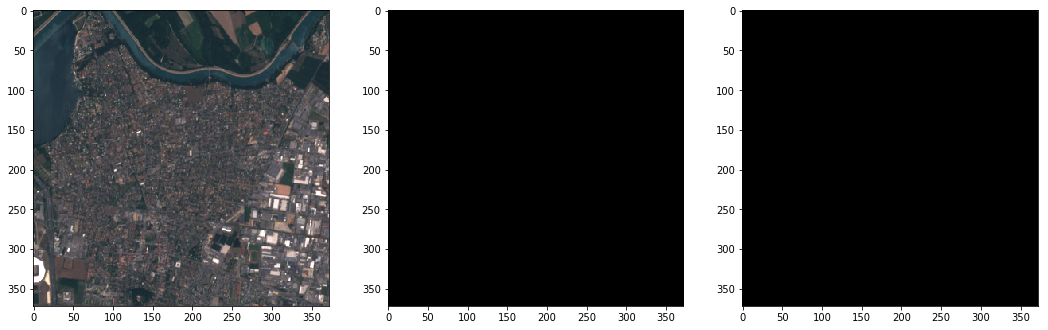

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


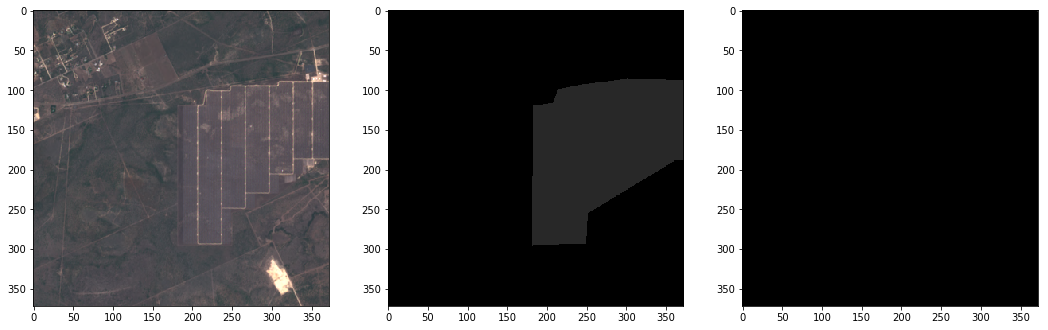

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


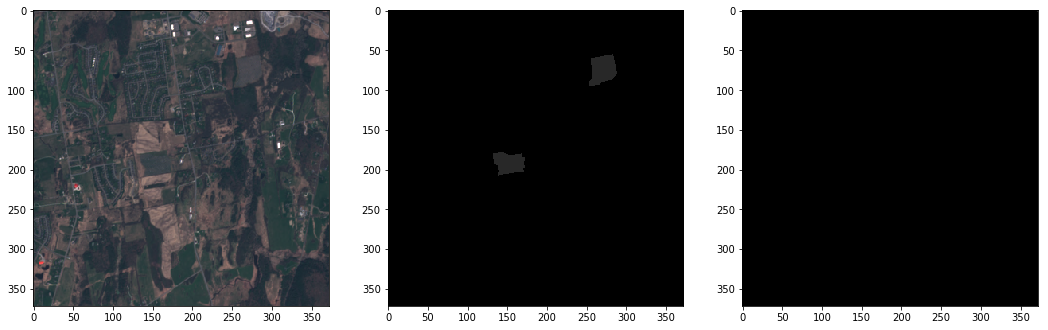

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


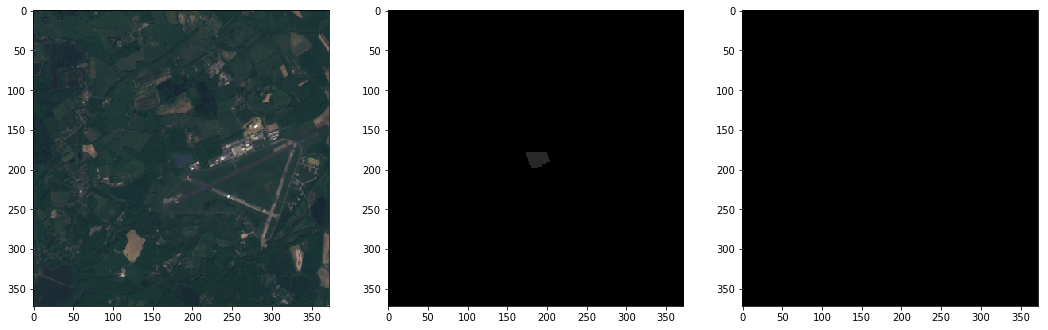

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


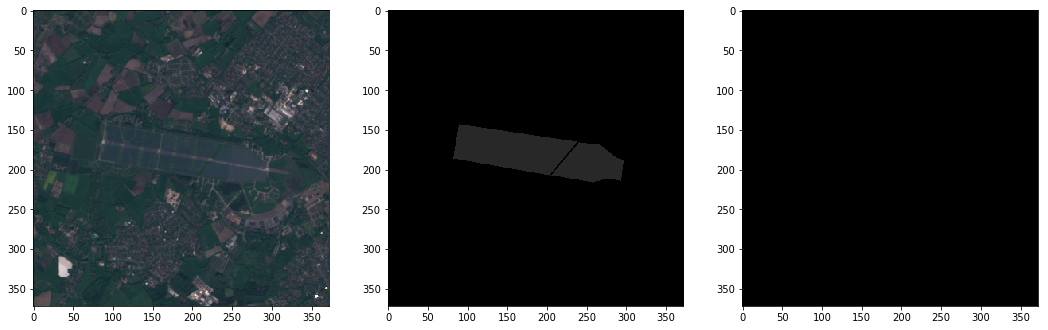

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


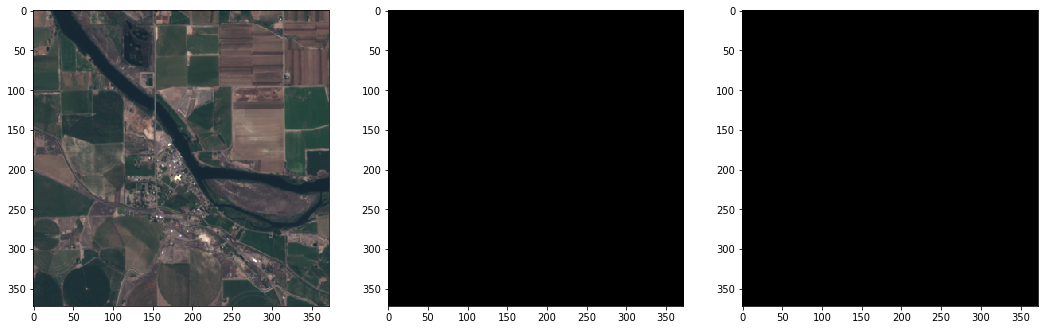

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


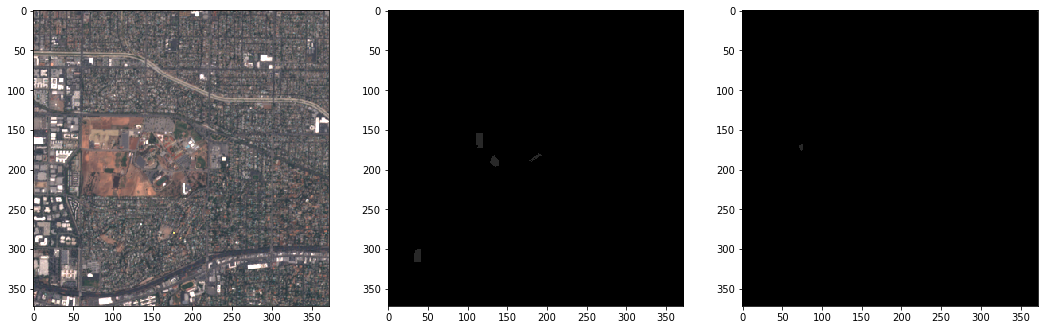

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


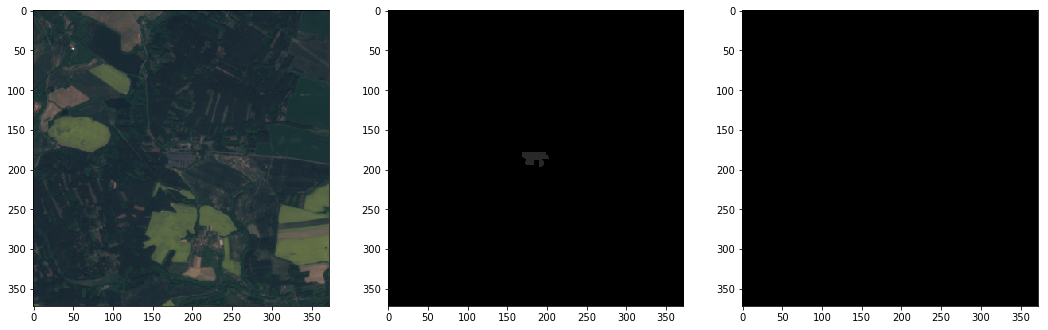

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


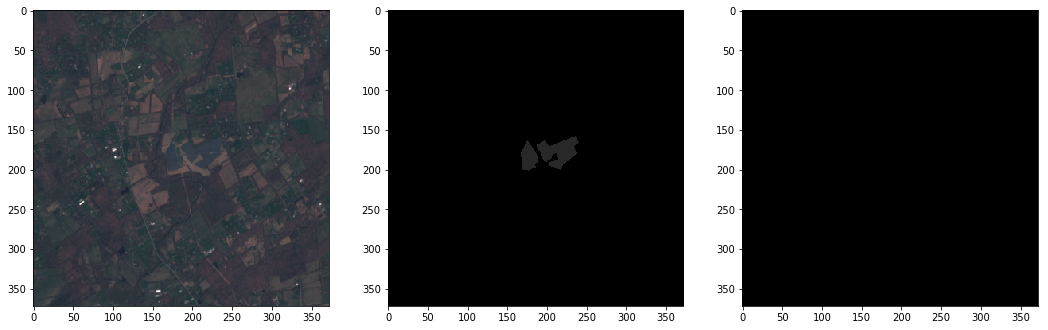

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


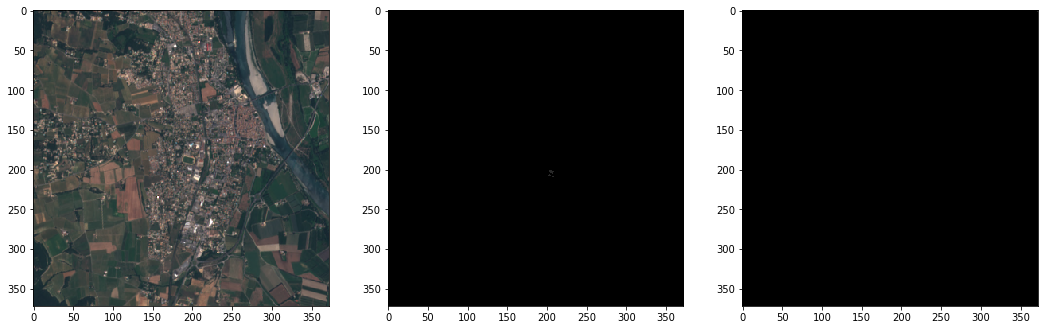

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


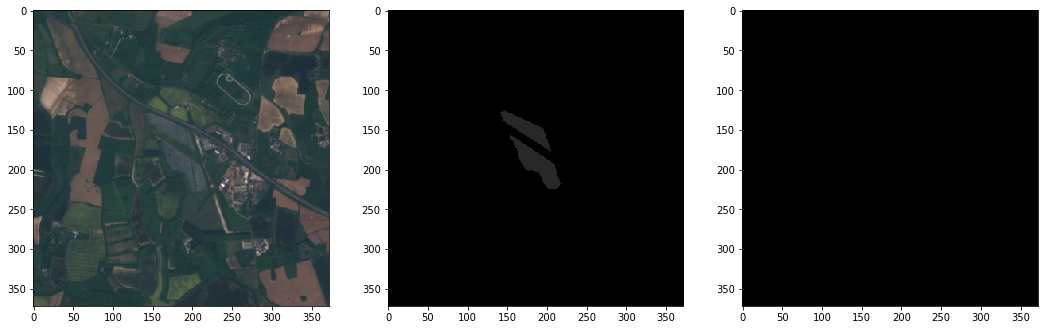

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


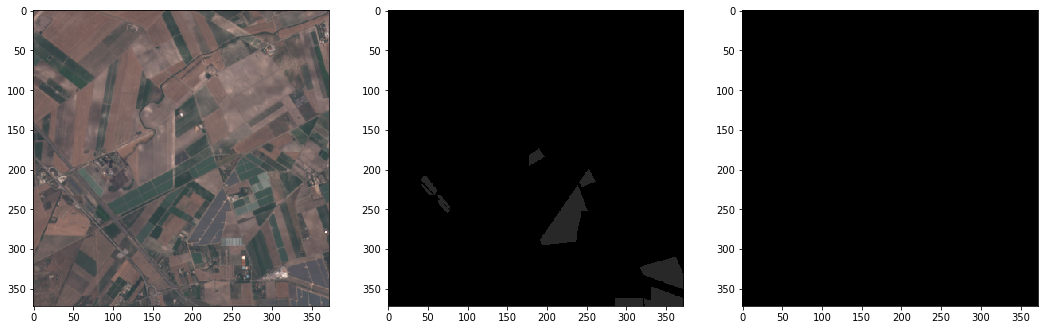

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


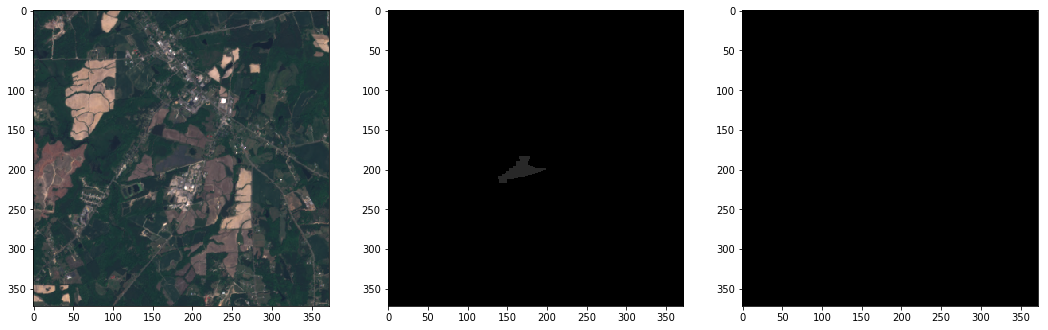

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


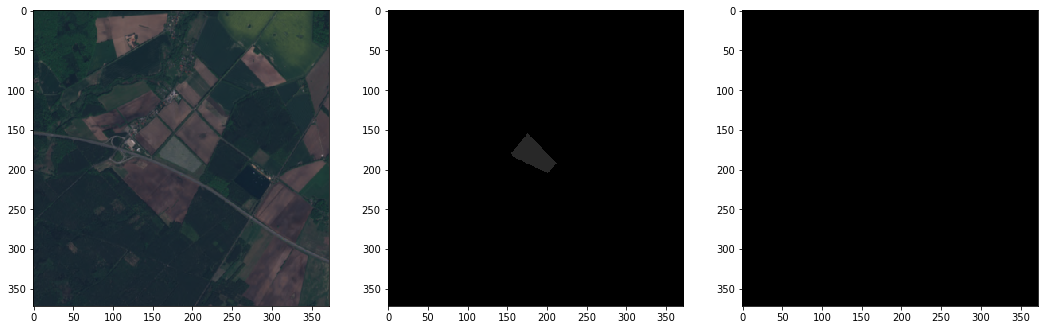

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


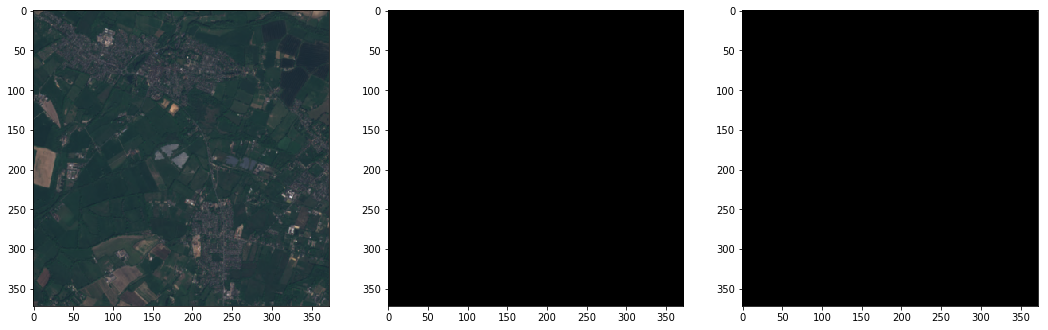

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


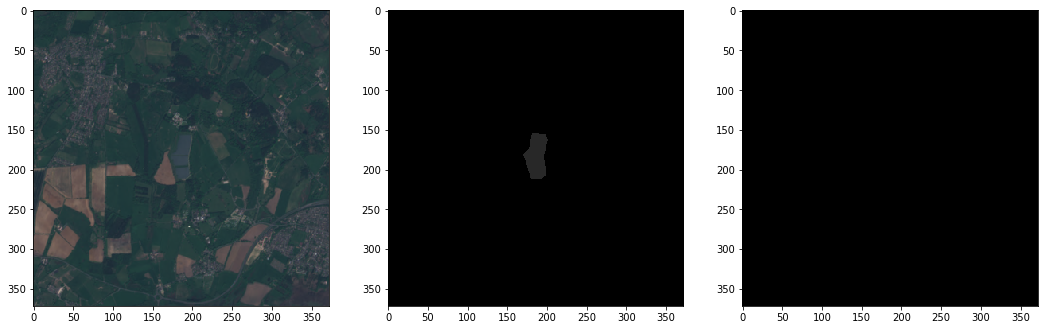

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


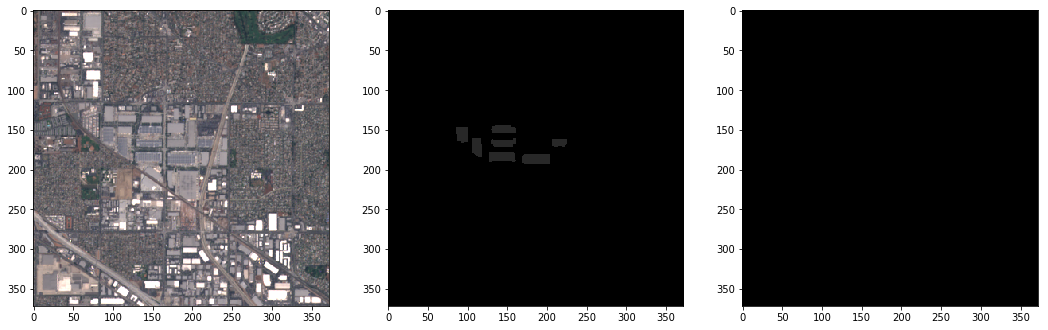

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


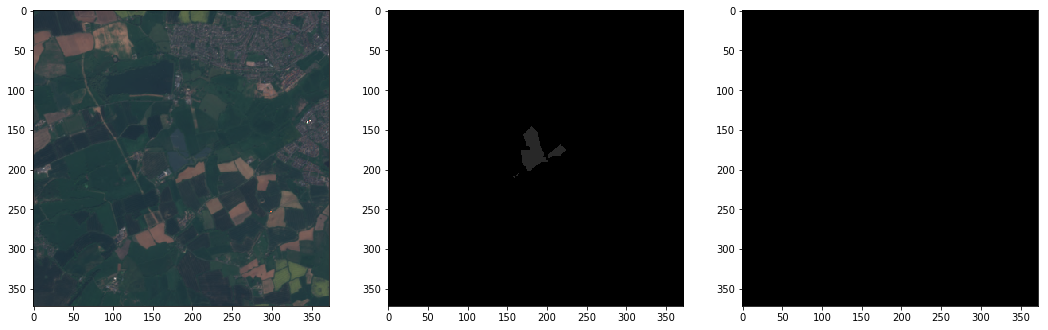

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


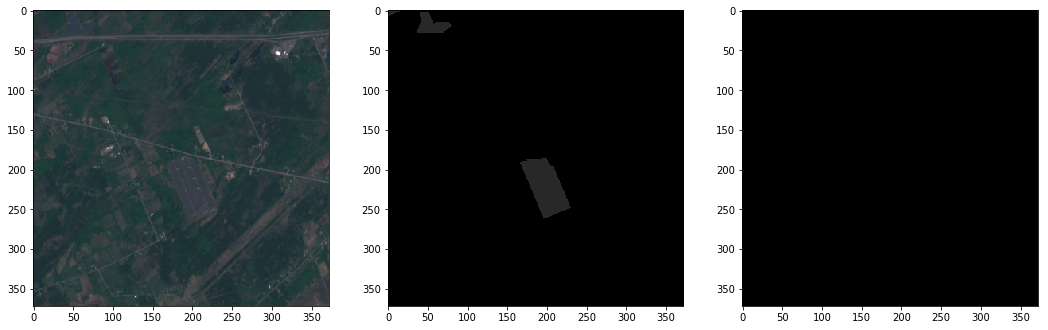

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


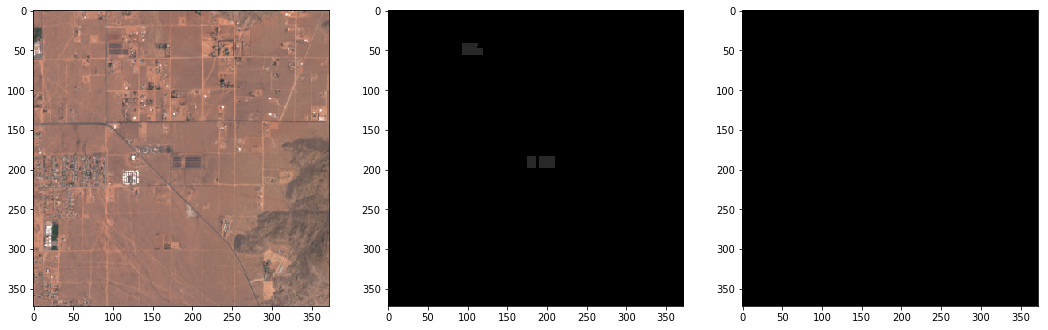

IndexError: index 20 is out of bounds for axis 0 with size 20

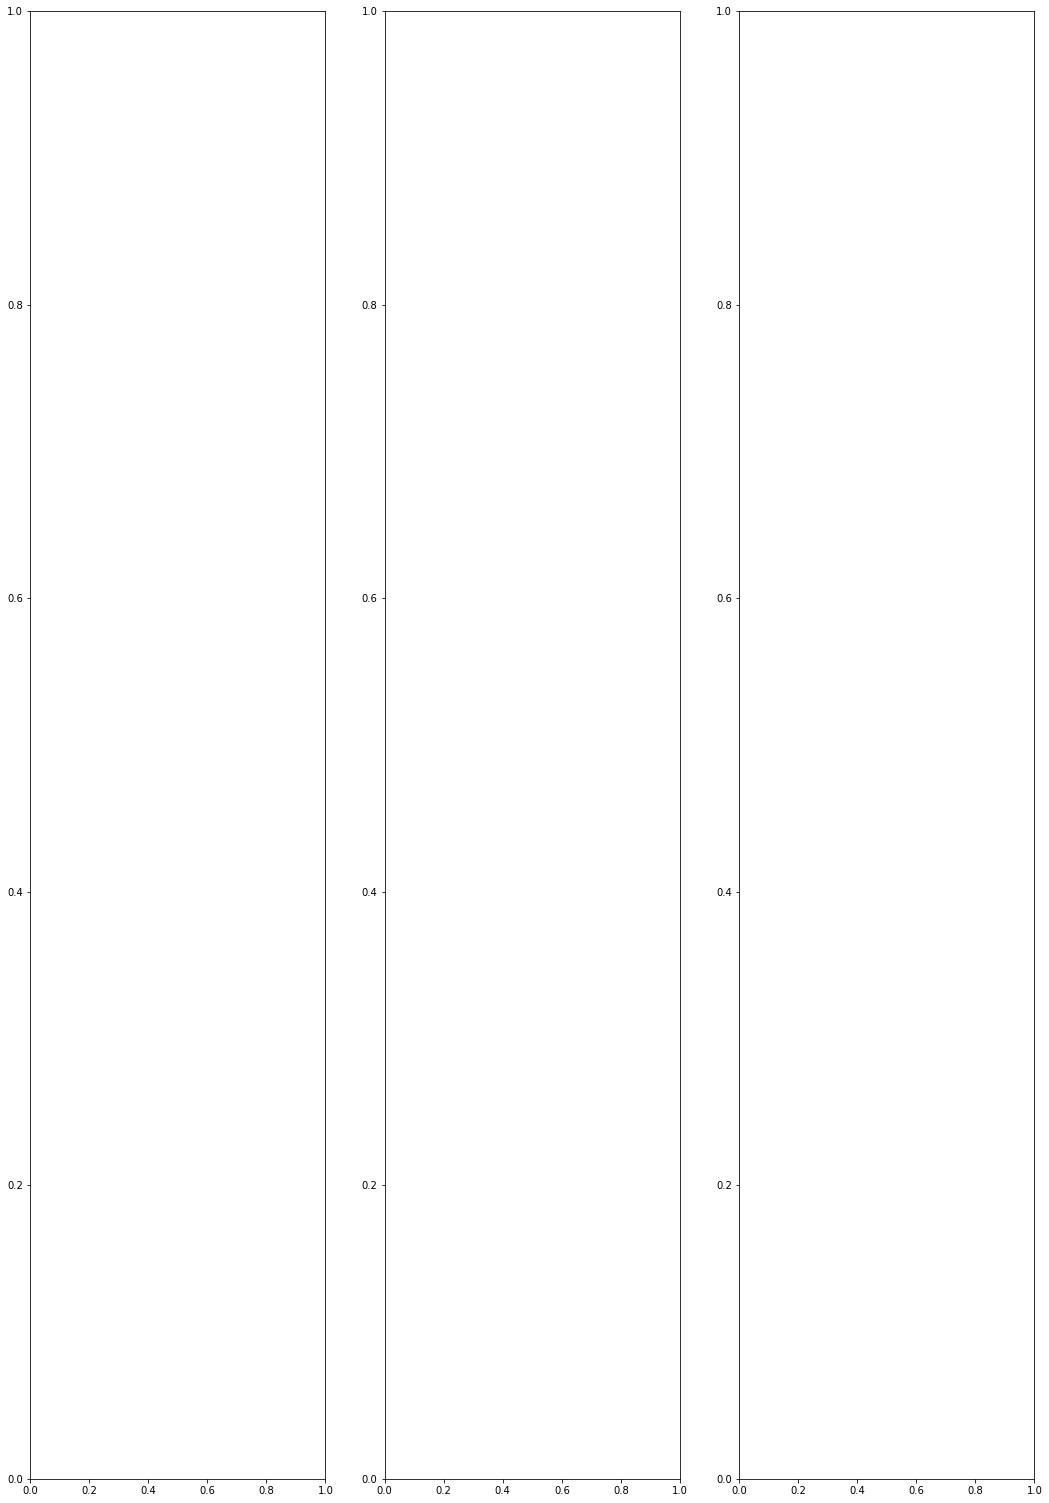

In [16]:
print (prediction.shape)
prediction_out = np.argmax(prediction,axis=-1)
print (prediction_out.shape)

for i in range(40):
    gamma = 2.5
    #save_image(np.argmax(prediction[i,:,:,:], axis=2), 'sample_out/sample_'+'_'+str(i)+'_PRED.png')
    #save_image(train_images_sample[i,:,:,0:3], 'sample_out/sample_'+'_'+str(i)+'_INPUT.png')
    #save_image(np.argmax(train_annotations_sample[i,:,:,:], axis=2), 'sample_out/sample_'+'_'+str(i)+'_TRUE.png')
    fig, axs = plt.subplots(1,3, figsize=(18,27))
    axs[0].imshow(Image.fromarray((train_images_sample[i,:,:,0:3]*gamma*255.).clip(0,255).astype('uint8')))
    axs[1].imshow(Image.fromarray((np.argmax(train_annotations_sample[i,:,:,:], axis=2)*40).astype('uint8')))
    axs[2].imshow(Image.fromarray((np.argmax(prediction[i,:,:,:], axis=2)*40).astype('uint8')))
    #axs[2].imshow(Image.fromarray((prediction[i,:,:,2]*23).astype('uint8')))
    print (np.argmax(prediction[i,:,:,:],axis=2))
    plt.show()
    
    
    
    

In [29]:
def IoU(prediction, annotation):
    #prediciton and annotation should have the same shape: (m,w,l,n_c)
    n_c = annotation.shape[-1]
    prediction = np.argmax(prediction, axis=-1)
    annotation = np.argmax(annotation, axis=-1)
    intersections = {}
    unions = {}
    for c in range(n_c):
        prediction_c = prediction==c
        annotation_c = annotation==c
        #intersection = AND(a,b) = a*b
        #union = OR(a,b) = a+b
        intersection_c = prediction_c*annotation_c
        union_c = prediction_c+annotation_c
        intersections[c] = np.sum(intersection_c)
        unions[c] = np.sum(union_c)
    return intersections, unions

In [30]:
intersections, unions = IoU(prediction,train_annotations_sample)

for c,v in intersections.items():
    print ('for class ',c,' IoU was ',float(v)/unions[c])

for class  0  IoU was  0.7312491738802434
for class  1  IoU was  0.14719499129718583
for class  2  IoU was  0.0007892659826361484
for class  3  IoU was  0.4085809706497704
for class  4  IoU was  0.3849659014110467
for class  5  IoU was  0.7150645417649156
for class  6  IoU was  0.9937573183490498


In [31]:
def conf_mat(prediction, annotation):
    #prediciton and annotation should have the same shape: (m,w,l,n_c)
    n_c = annotation.shape[-1]
    total = annotation.shape[0]*annotation.shape[1]*annotation.shape[2]
    prediction = np.argmax(prediction, axis=-1)
    annotation = np.argmax(annotation, axis=-1)
    out_mat = np.zeros((n_c,n_c))
    for c_1 in range(n_c):
        #print (c_1)
        prediction_c = prediction==c_1
        for c_2 in range(n_c):
            annotation_c = annotation==c_2
            total_c = np.sum(annotation_c)
            out_mat[c_1,c_2] = np.round(np.sum(prediction_c*annotation_c)/total_c,2)
    return out_mat
            

In [32]:
conf_mat = conf_mat(prediction,train_annotations_sample)
print (conf_mat)

[[0.89 0.31 0.25 0.28 0.29 0.13 0.  ]
 [0.01 0.17 0.06 0.05 0.   0.01 0.  ]
 [0.   0.   0.01 0.   0.   0.   0.  ]
 [0.1  0.49 0.04 0.62 0.27 0.03 0.  ]
 [0.   0.   0.   0.01 0.41 0.   0.  ]
 [0.01 0.03 0.17 0.04 0.04 0.83 0.  ]
 [0.   0.   0.47 0.   0.   0.   1.  ]]


In [33]:

weights = semseg_model.get_weights()
print (len(weights))
for w in weights:
    print(w.shape)



np.savez(open('weights.npz','wb'),weights)

46
(3, 3, 3, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(3, 3, 128, 256)
(256,)
(3, 3, 256, 256)
(256,)
(3, 3, 256, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 1024)
(1024,)
(3, 3, 1024, 1024)
(1024,)
(2, 2, 1024, 512)
(512,)
(3, 3, 1024, 512)
(512,)
(3, 3, 512, 512)
(512,)
(2, 2, 512, 256)
(256,)
(3, 3, 512, 256)
(256,)
(3, 3, 256, 256)
(256,)
(2, 2, 256, 128)
(128,)
(3, 3, 256, 128)
(128,)
(3, 3, 128, 128)
(128,)
(2, 2, 128, 64)
(64,)
(3, 3, 128, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 7)
(7,)


In [34]:
from keras.models import model_from_json

# serialize model to JSON
model_json = semseg_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
